In [2]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [3]:
#Acesso às pastas contendo os arquivos de áudio de cada ator

dir_list = os.listdir('Documents/Faculdade/TCC/audios/Actor_01')
dir_list.sort()
print (dir_list)

['03-01-01-01-01-01-01.wav', '03-01-01-01-01-02-01.wav', '03-01-01-01-02-01-01.wav', '03-01-01-01-02-02-01.wav', '03-01-02-01-01-01-01.wav', '03-01-02-01-01-02-01.wav', '03-01-02-01-02-01-01.wav', '03-01-02-01-02-02-01.wav', '03-01-02-02-01-01-01.wav', '03-01-02-02-01-02-01.wav', '03-01-02-02-02-01-01.wav', '03-01-02-02-02-02-01.wav', '03-01-03-01-01-01-01.wav', '03-01-03-01-01-02-01.wav', '03-01-03-01-02-01-01.wav', '03-01-03-01-02-02-01.wav', '03-01-03-02-01-01-01.wav', '03-01-03-02-01-02-01.wav', '03-01-03-02-02-01-01.wav', '03-01-03-02-02-02-01.wav', '03-01-04-01-01-01-01.wav', '03-01-04-01-01-02-01.wav', '03-01-04-01-02-01-01.wav', '03-01-04-01-02-02-01.wav', '03-01-04-02-01-01-01.wav', '03-01-04-02-01-02-01.wav', '03-01-04-02-02-01-01.wav', '03-01-04-02-02-02-01.wav', '03-01-05-01-01-01-01.wav', '03-01-05-01-01-02-01.wav', '03-01-05-01-02-01-01.wav', '03-01-05-01-02-02-01.wav', '03-01-05-02-01-01-01.wav', '03-01-05-02-01-02-01.wav', '03-01-05-02-02-01-01.wav', '03-01-05-02-02-02-

In [4]:
# Criação do data frame contendo as informações dos arquivos de áudio
initial_df = pd.DataFrame(columns=['path', 'emotion','intensity',
                                   'statement','repeat', 'actor', 'gender'])

count = 0
for i in dir_list:
    file_name = i.split('.')[0].split('-')
    path = 'Documents/Faculdade/TCC/audios/Actor_01'+ '/' + i
    actor = int(file_name[-1])
    emotion = int(file_name[2])
    
    gender = "male"
    
    if file_name[3] == '01':
            intensity = 'normal'
    else:
        intensity = 'strong'
        
    if file_name[4] == '01':
        statement = 'statement 1'
    else:
        statement = 'statement 2'
        
    if file_name[5] == '01':
        repeat = 1
    else:
        repeat = 2
            
    initial_df.loc[count] = [path, emotion, intensity, statement, repeat, actor, gender]
    count += 1

In [5]:
print (len(initial_df))
initial_df.head()

60


,path,emotion,intensity,statement,repeat,actor,gender
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 1,1,1,male
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 1,2,1,male
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 2,1,1,male
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 2,2,1,male
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,2,normal,statement 1,1,1,male


In [6]:
filename = initial_df.path[16]
print (filename)

Documents/Faculdade/TCC/audios/Actor_01/03-01-03-02-01-01-01.wav


In [7]:
samples, sample_rate = librosa.load(filename)
sample_rate, samples

(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [8]:
# Corte do áudio para retirar a parte silenciosa
trim, trim_rate = librosa.effects.trim(samples, top_db=30)
trim, trim_rate

(array([ 5.9528802e-06, -6.3385875e-07, -1.4023975e-07, ...,
        -3.5451894e-04, -2.0831003e-04, -1.4013593e-04], dtype=float32),
 array([22016, 58880]))

In [9]:
# Áudio original
ipd.Audio(samples, rate=sample_rate)

In [10]:
# Áudio após o corte
ipd.Audio(trim, rate=sample_rate)

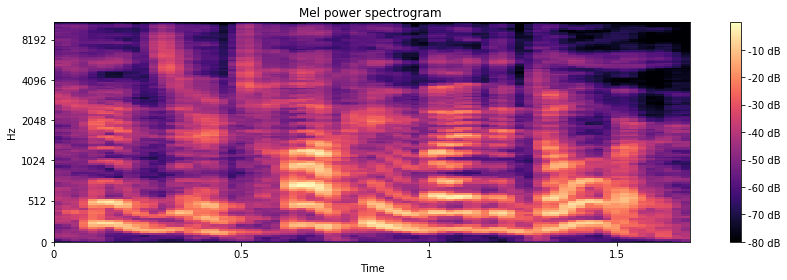

In [11]:
# Geração do espectrograma Mel Power

S = librosa.feature.melspectrogram(trim, sr=sample_rate, n_mels=128)

# Converte pra db
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

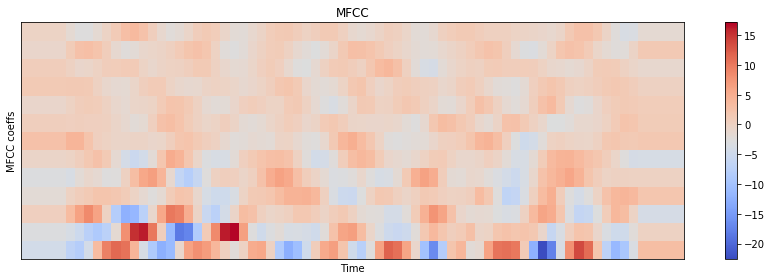

In [12]:
# Geração do MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [13]:
# Definindo um label para cada arquivo considerando a emoção

label_list = []
for i in range(len(initial_df)):
    if initial_df.emotion[i] == 1:
        lb = "neutral"
    elif initial_df.emotion[i] == 2:
        lb = "calm"
    elif initial_df.emotion[i] == 3:
        lb = "happy"
    elif initial_df.emotion[i] == 4:
        lb = "sad"
    elif initial_df.emotion[i] == 5:
        lb = "angry"
    elif initial_df.emotion[i] == 6:
        lb = "fearful"
    elif initial_df.emotion[i] == 7:
        lb = "disgust"
    elif initial_df.emotion[i] == 8:
        lb = "surprised"
         
    label_list.append(lb)
    
len(label_list)

60

In [14]:
initial_df['label'] = label_list
initial_df.head()

,path,emotion,intensity,statement,repeat,actor,gender,label
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 1,1,1,male,neutral
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 1,2,1,male,neutral
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 2,1,1,male,neutral
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 2,2,1,male,neutral
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,2,normal,statement 1,1,1,male,calm


In [15]:
#Criação de um data frame separado apenas para uma das frases
df_male = initial_df[initial_df.statement != "statement 2"].reset_index(drop=True)
df_male.head()

,path,emotion,intensity,statement,repeat,actor,gender,label
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 1,1,1,male,neutral
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,1,normal,statement 1,2,1,male,neutral
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,2,normal,statement 1,1,1,male,calm
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,2,normal,statement 1,2,1,male,calm
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,2,strong,statement 1,1,1,male,calm


In [16]:
len(df_male)

30

In [17]:
# Geração de um dataframe contendo apenas os valores de feature do mfccs feminino
df_feature_fem = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(df_male))):
    X, sample_rate = librosa.load(df_male.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    df_feature_fem.loc[i] = [feature]

100%|██████████| 30/30 [00:01<00:00, 16.34it/s]


In [18]:
df_feature_fem.head()

,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-61.84994, -62.89504, -63.830635, -60.552586,..."
2,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
3,"[-67.55739, -67.55739, -67.55739, -67.55739, -..."
4,"[-73.84137, -73.84137, -73.84137, -73.71965, -..."


In [19]:
#Conversão dos valores de feature obtidos em uma lista de features
male_feature = pd.DataFrame(df_feature_fem['feature'].values.tolist())
male_labels = initial_df.label

In [20]:
male_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370


In [21]:
feature_lbl = pd.concat([male_feature,male_labels], axis=1)

In [22]:
feature_labels = feature_lbl.rename(index=str, columns={"0": "label"})
len(feature_labels)

60

In [23]:
feature_labels.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,neutral
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,neutral
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,calm
5,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-57.185970,-61.188725,-67.108391,-67.508125,-66.245537,-68.733047,-69.243256,-69.243256,-69.243256,calm
6,-63.311062,-63.072487,-63.412422,-63.796757,-63.581989,-58.921223,-57.955044,-61.224972,-63.782932,-63.796757,...,-63.740608,-62.410255,-62.489079,-62.494453,-62.632626,-62.824276,NaN,NaN,NaN,calm
7,-60.369045,-60.083717,-60.978924,-60.952457,-60.982483,-60.983948,-60.981255,-60.981255,-60.981255,-60.249615,...,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,NaN,NaN,NaN,calm
8,-58.731003,-58.746517,-58.048584,-57.370796,-58.199924,-59.706638,-59.876179,-59.998066,-59.936649,-60.248569,...,-60.248569,-60.248569,-60.248569,-60.248569,-60.248569,-60.248569,-60.248569,-60.248569,-60.248569,calm
9,-56.733879,-56.752663,-56.415257,-55.715679,-55.817852,-55.832748,-55.889751,-55.116520,-54.244675,-56.211891,...,-56.756023,-56.756023,-56.756023,-56.756023,-56.756023,-56.756023,-56.756023,-56.756023,-56.756023,calm


In [24]:
#Geração do gráfico de frequência da voz
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

#Reduzir o barulho
def noise(data):
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

#Organizar as linhas do array de forma aleatória
def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

#Esticar o som
def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

#Afinar o tom da voz
def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

#Mudar valores de forma aleatória
def dyn_change(data):
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)

#Alterar velocidade do tom
def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [25]:
# Aplicação de um método de Augmentation

syn_data1f = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(initial_df))):
    X, sample_rate = librosa.load(initial_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if initial_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1f.loc[i] = [feature, initial_df.label[i]]

100%|██████████| 60/60 [00:03<00:00, 15.79it/s]


In [26]:
# Aplicação de outro método de Augmentation

syn_data2f = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(initial_df))):
    X, sample_rate = librosa.load(initial_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if initial_df.label[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2f.loc[i] = [feature, initial_df.label[i]]

100%|██████████| 60/60 [00:15<00:00,  3.87it/s]


In [27]:
len(syn_data1f), len(syn_data2f)

(60, 60)

In [28]:
syn_data1f = syn_data1f.reset_index(drop=True)
syn_data2f = syn_data2f.reset_index(drop=True)

In [30]:
featf = pd.DataFrame(syn_data1f['feature'].values.tolist())
labelsf = syn_data1f.label
syndf1 = pd.concat([featf,labelsf], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

60

In [31]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-62.645916,-62.795803,-60.409039,-60.457161,-58.140476,-58.009750,-61.311672,-61.493225,-58.085903,-56.578533,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,neutral
1,-57.694248,-55.507561,-54.827999,-53.782269,-51.896248,-54.168762,-55.018719,-55.028221,-54.867794,-56.427406,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,neutral
2,-57.238869,-55.008625,-53.889225,-54.238499,-52.739128,-54.549412,-54.789207,-54.151299,-52.214817,-51.644466,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,neutral
3,-48.938576,-48.688015,-50.305363,-49.632484,-49.565350,-49.616276,-49.903564,-51.166100,-49.895779,-48.833694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,neutral
4,-65.777298,-63.148750,-62.116699,-63.169670,-62.002239,-61.880417,-61.605915,-62.787563,-61.775082,-61.814674,...,-62.188721,-60.744503,-59.925388,-59.890068,-59.068375,-60.433998,-61.3983,-61.800968,-61.480022,calm


In [32]:
featf2 = pd.DataFrame(syn_data2f['feature'].values.tolist())
labelsf2 = syn_data2f.label
syndf2 = pd.concat([featf2,labelsf2], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

60

In [33]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-68.946030,-68.946030,-68.946030,-68.946030,-68.946030,-68.946030,-68.946030,-68.946030,-68.946030,-68.946030,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1,-62.529823,-64.165787,-65.412209,-64.257370,-64.494286,-66.313141,-67.746284,-68.328339,-68.328339,-68.328339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
2,-69.235321,-69.235321,-69.235321,-69.166763,-69.214096,-69.235321,-69.235321,-69.235321,-69.235321,-68.849564,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
3,-67.625061,-67.625061,-67.625061,-67.625061,-67.625061,-67.625061,-67.625061,-67.625061,-67.625061,-67.625061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
4,-73.654221,-73.654221,-73.654221,-73.654221,-73.654221,-73.654221,-73.654221,-73.654221,-73.654221,-73.654221,...,-73.654221,-73.654221,-73.643478,-72.952248,-73.158585,-73.299156,-72.995163,-73.361931,-73.654221,calm


In [35]:
# Combinar os dados Augmented com os originais
combined_df_fem = pd.concat([feature_labels, syndf1, syndf2], ignore_index=True)
combined_df_fem = combined_df_fem.fillna(0)
combined_df_fem.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,neutral
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,neutral
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,calm


In [37]:
#  Stratified Shuffle Split - divide a base em treino e teste 

X = combined_df_fem.drop(['label'], axis=1)
y = combined_df_fem.label
data_split = StratifiedShuffleSplit(10, test_size=0.25, random_state=12)
for train_index, test_index in data_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [38]:
y_train.value_counts()

fearful      18
calm         18
disgust      18
surprised    18
sad          18
angry        18
happy        18
neutral       9
Name: label, dtype: int64

In [39]:
#Converter os dados de treino e teste em arrays numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
#Converter os dados do array em dados categóricos
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [40]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
X_train.shape

(135, 259)

In [43]:
#Expande as dimensões do array
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [44]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [46]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

Instructions for updating:
Colocations handled automatically by placer.


In [47]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [48]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [49]:
# Model Training
filepath="aug_noiseNshift_2class2_np.h5"
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=20,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Instructions for updating:
Use tf.cast instead.
Train on 135 samples, validate on 45 samples
Epoch 1/20
135/135 [==============================] - 4s 30ms/step - loss: 2.2756 - accuracy: 0.1481 - fscore: 0.0000e+00 - val_loss: 2.1685 - val_accuracy: 0.1111 - val_fscore: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 3s 22ms/step - loss: 2.1237 - accuracy: 0.1481 - fscore: 0.0000e+00 - val_loss: 2.1554 - val_accuracy: 0.1111 - val_fscore: 0.0000e+00
Epoch 3/20
135/135 [==============================] - 3s 22ms/step - loss: 2.1266 - accuracy: 0.1333 - fscore: 0.0131 - val_loss: 2.1429 - val_accuracy: 0.1111 - val_fscore: 0.0000e+00
Epoch 4/20
135/135 [==============================] - 3s 22ms/step - loss: 2.0440 - accuracy: 0.1556 - fscore: 0.0131 - val_loss: 2.1327 - val_accuracy: 0.1111 - val_fscore: 0.0000e+00
Epoch 5/20
135/135 [==============================] - 3s 21ms/step - loss: 2.0351 - accuracy: 0.1778 - fscore: 0.0000e+00 - val_loss: 2.1218 - val_accuracy: 0.

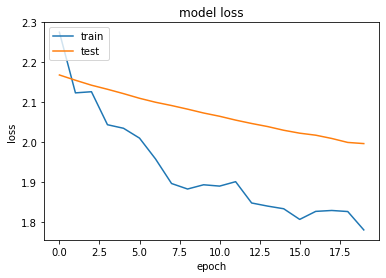

In [50]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [52]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 20.00%


In [56]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(df_male))):
    X, sample_rate = librosa.load(df_male.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(df_male.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 30/30 [00:01<00:00, 17.42it/s]


In [58]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

30/30 [==============================] - 0s 7ms/step


In [59]:
preds

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.10997353, 0.15245579, 0.11815136, 0.09608498, 0.1243603 ,
        0.10041451, 0.15596849, 0.14259106],
       [0.11397049, 0.15647055, 0.11964827, 0.10277092, 0.13600077,
        0.09424154, 0.14856967, 0.12832783],
       [0.11192141, 0.16044126, 0.12672915, 0.09821301, 0.12962177,
        0.09022199, 0.14599258, 0.13685884],
       [0.11356342, 0.14225715, 0.13969103, 0.10712899, 0.12961002,
        0.09754623, 0.12793392, 0.14226927],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.11557941, 0.14753911, 0.11264844, 0.11025589, 0.14159475,
        0.0983575 , 0.149960

In [60]:
preds1=preds.argmax(axis=1)

In [61]:
preds

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.10997353, 0.15245579, 0.11815136, 0.09608498, 0.1243603 ,
        0.10041451, 0.15596849, 0.14259106],
       [0.11397049, 0.15647055, 0.11964827, 0.10277092, 0.13600077,
        0.09424154, 0.14856967, 0.12832783],
       [0.11192141, 0.16044126, 0.12672915, 0.09821301, 0.12962177,
        0.09022199, 0.14599258, 0.13685884],
       [0.11356342, 0.14225715, 0.13969103, 0.10712899, 0.12961002,
        0.09754623, 0.12793392, 0.14226927],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.11557941, 0.14753911, 0.11264844, 0.11025589, 0.14159475,
        0.0983575 , 0.149960

In [62]:
flatten_preds = preds1.astype(int).flatten()

In [63]:
predictions = (lb.inverse_transform((flatten_preds)))

In [64]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,angry
1,angry
2,sad
3,calm
4,calm
5,surprised
6,angry
7,angry
8,sad
9,sad


In [65]:
actual=test_valid_lb.argmax(axis=1)
actual_flatten = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((actual_flatten)))

In [66]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,neutral
1,neutral
2,calm
3,calm
4,calm
5,calm
6,happy
7,happy
8,happy
9,happy


In [67]:
finaldf = actualdf.join(preddf)

In [68]:
finaldf

,actualvalues,predictedvalues
0,neutral,angry
1,neutral,angry
2,calm,sad
3,calm,calm
4,calm,calm
5,calm,surprised
6,happy,angry
7,happy,angry
8,happy,sad
9,happy,sad


In [69]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,4
calm,4
disgust,4
fearful,4
happy,4
neutral,2
sad,4
surprised,4


In [70]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,7
calm,8
happy,6
sad,7
surprised,2


In [71]:
finaldf.to_csv('Predictions.csv', index=False)

In [72]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [73]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

13.333333333333334

In [74]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

8.712121212121213

In [75]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[0, 1, 0, 0, 2, 0, 1, 0],
       [0, 2, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 4, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 1, 1],
       [2, 0, 0, 0, 0, 0, 2, 0],
       [2, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 2, 0],
       [3, 1, 0, 0, 0, 0, 0, 0]])

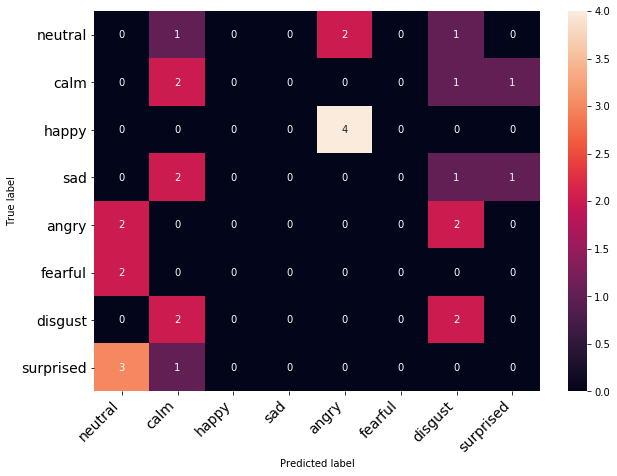

In [76]:
# Visualize Confusion Matrix 

class_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print_confusion_matrix(cm, class_names)